# 1. Preprocessing Libraries
## These libraries help clean and prepare text data for sentiment analysis.

In [1]:
!pip install -q nltk regex unidecode emoji tqdm wordcloud matplotlib seaborn gensim numpy tensorflow scikit-learn pandas


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [45]:
# These libraries help clean and prepare text data for sentiment analysis.
import nltk
import re
import string
import unidecode
import emoji
from tqdm import tqdm
import wordcloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Used to convert text into numerical representations.

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim
import numpy as np

# TensorFlow and Keras layers for building the Bidirectional LSTM model.

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.layers import LayerNormalization
import tensorflow as tf
from tensorflow.keras.regularizers import l2

# Used for evaluating model performance.

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


# Data handling and file management.

import pandas as pd
import pickle
import os

# **Splitting the Dataset into Train, Validation, and Test Sets**
# Load Dataset From `CSV` File using pandas.

In [25]:
# Load the dataset
file_path = "/kaggle/input/news-sentiment-analysis/news.csv"
df = pd.read_csv(file_path)

# Display the first few rows to understand the structure of the dataset
df.head(10)

,date,news,neg,neu,pos,compound,sentiment
0,2007-07-07,It was a long antipodean night. While there’s ...,0.059000,0.878000,0.064000,0.051600,POSITIVE
1,2007-07-07,In Mexico there are no licensing or registrati...,0.044000,0.956000,0.000000,-0.296000,NEGATIVE
2,2007-07-07,The government has until Monday to protect the...,0.000000,0.894000,0.106000,0.381800,POSITIVE
3,2007-07-07,A record-breaking heat wave in the Southwest i...,0.197505,0.661490,0.141005,0.997491,POSITIVE
4,2007-07-07,England started its Live Earth concert at Wemb...,0.033000,0.945000,0.022000,-0.177900,NEGATIVE
5,2007-07-07,The Lewis Hamilton effect is felt everywhere. ...,0.000000,0.965000,0.035000,0.361200,POSITIVE
6,2007-07-07,The Sam’s Army ratings polls reflect the gener...,0.102000,0.786000,0.112000,0.340000,POSITIVE
7,2008-06-08,b'Chiapas: army occupies Zapatista communities...,0.241577,0.735335,0.023087,0.943535,NEGATIVE
8,2008-06-08,"b""Canada: Beware slippery slope' to censorship...",0.609306,0.375088,0.015605,0.967464,NEGATIVE
9,2008-06-08,"b""Oil reserves 'will last decades' - a BBC Sco...",0.238956,0.713291,0.047753,0.791826,NEGATIVE


In [5]:
print(f"The Dataset Shape \n Rows: {df.shape[0]} X  Columns: {df.shape[1]}")

The Dataset Shape 
 Rows: 427482 X  Columns: 7


## **Convert Sentiment Labels to Binary (0,1)**

In [6]:
# Map sentiment to binary labels
df['sentiment_label'] = df['sentiment'].map({'NEGATIVE': 0, 'POSITIVE': 1})

# Check the distribution of sentiment labels
df['sentiment_label'].value_counts()

sentiment_label
0    217443
1    210039
Name: count, dtype: int64

# Split Data into Train, Validation, and Test Sets
We will split the dataset as follows:

- 90% Train
- 10% Validation
- 10% Test

In [28]:

# Features (text) and targets 
X = df["news"]
y = df[["pos", "neg", "neu"]]  # Only use pos, neg, and neu

# First, split into Train (80%) and Temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Split Temp into Validation (10%) and Test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Extract pos, neg, neu separately
y_train_pos, y_train_neg, y_train_neu = y_train["pos"], y_train["neg"], y_train["neu"]
y_val_pos, y_val_neg, y_val_neu = y_val["pos"], y_val["neg"], y_val["neu"]
y_test_pos, y_test_neg, y_test_neu = y_test["pos"], y_test["neg"], y_test["neu"]

# Check dataset sizes
print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 341985
Validation size: 42748
Test size: 42749


## 2. Preprocess the Text
The following preprocessing steps will be applied:
- Lowercasing
- Removing special characters, numbers, and punctuation
- Removing stopwords
- Tokenizing and padding sequences
- Lemmatization


In [29]:
# Text Preprocessing function
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation

    # Remove accents/diacritics (for language normalization)
    text = unidecode.unidecode(text)
    
    return text

# **Apply Preprocessing to All Datasets**

In [30]:
# Apply preprocessing to Train, Validation, and Test datasets
X_train = X_train.apply(preprocess_text)
X_val = X_val.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)

In [31]:
X_train[2]

'the government has until monday to protect the redacted names of baseball players who were supplied performanceenhancing drugs by a former mets clubhouse attendant'

## 3. Tokenization & Stopword Removal
### Tokenize the text and remove common stopwords.

In [32]:
# Download stopwords from NLTK
nltk.download('stopwords')
from nltk.corpus import stopwords

# Get English stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
# Tokenization and stopword removal function
def tokenize_and_remove_stopwords(text):
    # Tokenize text (split by spaces)
    tokens = text.split()
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

In [34]:
# Apply tokenization and stopword removal
X_train = X_train.apply(tokenize_and_remove_stopwords)
X_val = X_val.apply(tokenize_and_remove_stopwords)
X_test = X_test.apply(tokenize_and_remove_stopwords)

In [35]:
# Display cleaned text
X_train.head()

339520    president bidens nominee assistant secretary h...
401705    younger audiences could see new royal drama hi...
230609    decision opposed progressive members church ga...
184144    lava burst kilauea began flowing eastern edge ...
3632                bfrance imam arrested illegal marriages
Name: news, dtype: object

# **Full Visualizations**

## 1. **Top 20 Most Frequent Words**

/tmp/ipykernel_169/2720541863.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


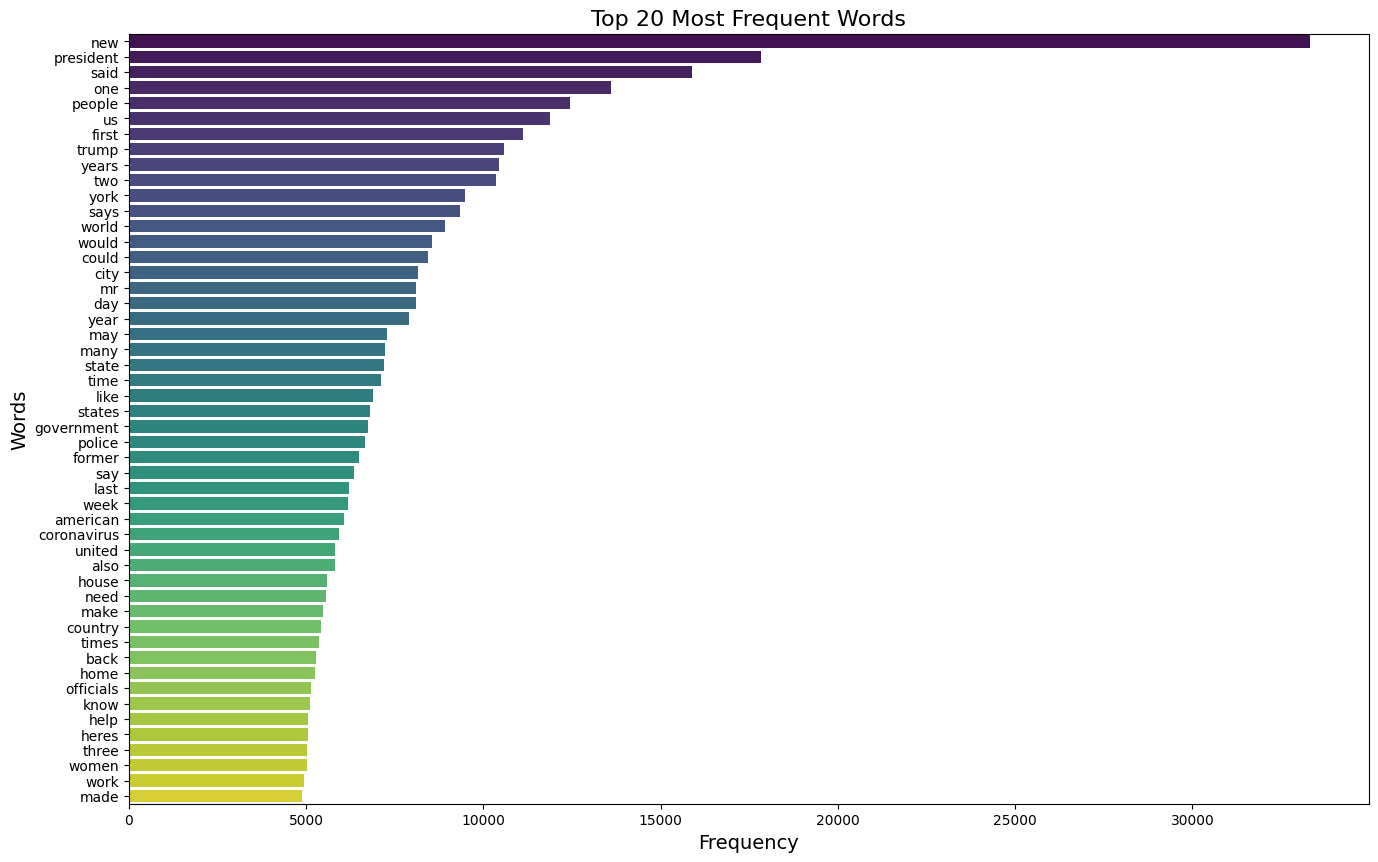

In [36]:
# Tokenizing all the cleaned text and counting word frequencies
all_words = X_train.str.split().explode()
word_counts = Counter(all_words.tolist())

# Get the top 20 most frequent words
most_common_words = word_counts.most_common(50)
words, counts = zip(*most_common_words)

# Plotting the word frequency distribution
plt.figure(figsize=(16, 10))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title('Top 20 Most Frequent Words', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Words', fontsize=14)
plt.show()

## **5. Plot: Word Cloud of Most Frequent Words**
This visualization is helpful to show the distribution of words more artistically.

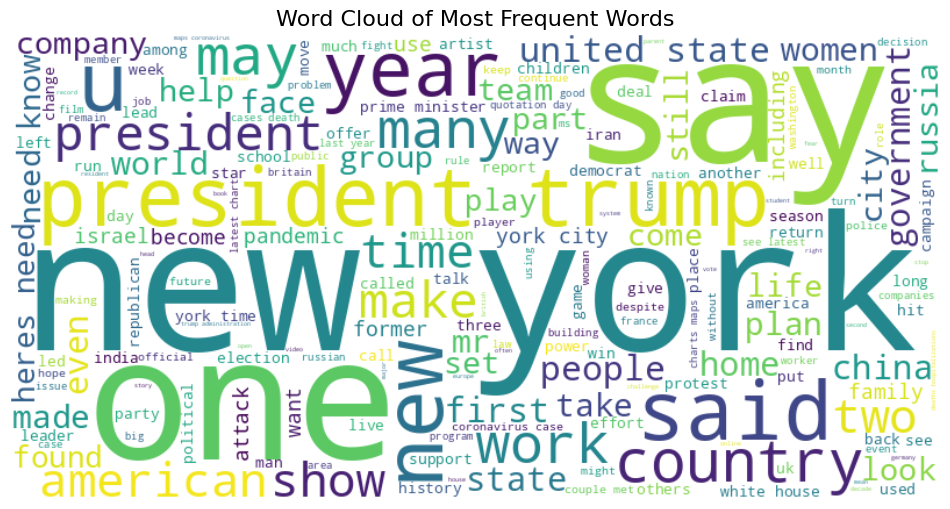

In [37]:
from wordcloud import WordCloud

# Create a word cloud of the most common words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(X_train))

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words', fontsize=16)
plt.show()

# Modeling 

## Loading the GloVe Pre-trained Model (`Text Embedding Model`)

In [38]:
# Path to the pre-trained GloVe 50D embeddings file
path = "/kaggle/input/glove6b50dtxt/glove.6B.50d.txt" 

# Load the GloVe model into Gensim using the load_word2vec_format method
glove_model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=False, no_header=True)

# Check if the model is loaded successfully
print(f"Loaded GloVe model with {len(glove_model.index_to_key)} words and {glove_model.vector_size} dimensions.")

Loaded GloVe model with 400000 words and 50 dimensions.


## **Define the Tokenizer and Create the Embedding Matrix**

In [39]:
# Define the maximum sequence length and embedding dimension
max_length = 100  # Adjust this based on your data
embedding_dim = glove_model.vector_size  # This will be 50 for GloVe 50D

# Function to create an embedding matrix using GloVe embeddings
def create_embedding_matrix(tokenizer, glove_model, embedding_dim):
    # Create an embedding matrix with zeros
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

    # Fill the embedding matrix with GloVe vectors
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = glove_model[word]  # Get embedding from GloVe
            embedding_matrix[i] = embedding_vector  # Store the embedding in the matrix
        except KeyError:
            continue  # If word is not in GloVe, keep zero vector

    return embedding_matrix

## **Tokenize and Pad the `cleaned_text` Column**

In [40]:
def tokenize_and_pad(texts, max_length):
    """
    Tokenizes and pads a list of texts.

    Parameters:
    - texts (list or pandas Series): Input text data.
    - max_length (int): Maximum sequence length for padding.

    Returns:
    - X_padded (numpy array): Tokenized and padded sequences.
    - tokenizer (Tokenizer object): Fitted tokenizer.
    """
    # Initialize tokenizer
    tokenizer = Tokenizer()
    
    # Fit tokenizer on text data
    tokenizer.fit_on_texts(texts)
    
    # Convert texts to sequences
    X_sequences = tokenizer.texts_to_sequences(texts)
    
    # Pad sequences to ensure uniform length
    X_padded = pad_sequences(X_sequences, maxlen=max_length, padding='post', truncating='post')
    
    return X_padded, tokenizer

In [41]:
# Tokenize and pad training, validation, and test sets
X_train_padded, tokenizer = tokenize_and_pad(X_train, max_length)
X_val_padded, _ = tokenize_and_pad(X_val, max_length)
X_test_padded, _ = tokenize_and_pad(X_test, max_length)

# Print shapes to verify
print(f"X_train_padded shape: {X_train_padded.shape}")
print(f"X_val_padded shape: {X_val_padded.shape}")
print(f"X_test_padded shape: {X_test_padded.shape}")

X_train_padded shape: (341985, 100)
X_val_padded shape: (42748, 100)
X_test_padded shape: (42749, 100)


## **Create the Embedding Matrix Using the Tokenizer**

In [42]:
# Create the embedding matrix using the tokenizer and GloVe model
embedding_matrix = create_embedding_matrix(tokenizer, glove_model, embedding_dim)

# Print the shape of the embedding matrix to verify
print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (131760, 50)


## **Define Score Scaling**
To normalize the `compound` score between **0 and 1**, we apply **Min-Max Scaling**:

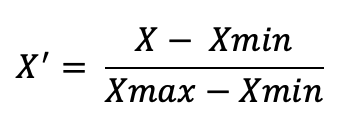
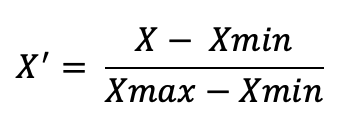

In [46]:
# Initialize the scaler
scaler = MinMaxScaler()

# Reshape and scale the target variables
y_train_neg_scaled = scaler.fit_transform(y_train_neg.values.reshape(-1, 1))
y_val_neg_scaled = scaler.transform(y_val_neg.values.reshape(-1, 1))
y_test_neg_scaled = scaler.transform(y_test_neg.values.reshape(-1, 1))

y_train_neu_scaled = scaler.fit_transform(y_train_neu.values.reshape(-1, 1))
y_val_neu_scaled = scaler.transform(y_val_neu.values.reshape(-1, 1))
y_test_neu_scaled = scaler.transform(y_test_neu.values.reshape(-1, 1))

y_train_pos_scaled = scaler.fit_transform(y_train_pos.values.reshape(-1, 1))
y_val_pos_scaled = scaler.transform(y_val_pos.values.reshape(-1, 1))
y_test_pos_scaled = scaler.transform(y_test_pos.values.reshape(-1, 1))

# Ensure no data leakage and prevent fitting the scaler on the test/validation sets
# The scaler is fit only on the training data, and transformation is applied to the validation/test sets

# Checking the scaled values
print("Scaled training targets:")
print(f"Neg: {y_train_neg_scaled[:5]}")
print(f"Neu: {y_train_neu_scaled[:5]}")
print(f"Compound: {y_train_pos_scaled[:5]}")

Scaled training targets:
Neg: [[0.108     ]
 [0.        ]
 [0.65830404]
 [0.31101978]
 [0.626     ]]
Neu: [[0.91020408]
 [0.93877551]
 [0.33979212]
 [0.67774112]
 [0.38163265]]
Compound: [[0.        ]
 [0.08      ]
 [0.00869978]
 [0.02479385]
 [0.        ]]


## **Set up TPU Strategy**

In [44]:
# Set up TPU strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    print("Running on TPU")
except ValueError:
    tpu = None
    print("Running on GPU or CPU")

# Connect to TPU
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.MirroredStrategy()  # Fallback for multi-GPU or CPU

print('Number of replicas:', strategy.num_replicas_in_sync)

Running on GPU or CPU
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


I0000 00:00:1740923423.624959     169 service.cc:148] XLA service 0x56c487b422a0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740923423.625005     169 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1740923423.625009     169 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1740923423.625012     169 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1740923423.625015     169 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1740923423.625017     169 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1740923423.625020     169 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1740923423.625022     169 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1740923423.625025     169 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


Number of replicas: 1


## **Build LSTM Model**

In [47]:
# Define TPU Strategy
with strategy.scope():
    # Define the input layers
    input_layer_text = Input(shape=(max_length,), name="input_text")  
    
    # Embedding layer for text data with pre-trained GloVe weights
    embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],  
                                output_dim=embedding_dim,  
                                weights=[embedding_matrix],  
                                trainable=True)(input_layer_text)  
    
    # First Bidirectional LSTM Layer
    lstm_layer_1 = Bidirectional(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.02)))(embedding_layer)
    norm_1 = LayerNormalization()(lstm_layer_1)  
    dropout_1 = Dropout(0.4)(norm_1)

    # Shared Fully Connected Layer
    dense_shared = Dense(64, activation='relu', kernel_regularizer=l2(0.03))(dropout_1)
    norm_3 = LayerNormalization()(dense_shared)
    dropout_3 = Dropout(0.5)(norm_3)  

    # Independent Outputs (Fixed)
    pos_output = Dense(1, activation='linear', name='pos_output')(Dense(32, activation='relu')(dropout_3))
    neg_output = Dense(1, activation='linear', name='neg_output')(Dense(32, activation='relu')(dropout_3))
    neu_output = Dense(1, activation='linear', name='neu_output')(Dense(32, activation='relu')(dropout_3))
    
    # Define the model with inputs and three outputs
    model = Model(inputs=input_layer_text, outputs=[pos_output, neg_output, neu_output])

    # Compile the model with multiple loss functions and Adam optimizer
    model.compile(optimizer=Adam(learning_rate=0.0005, clipnorm=1.0),  # Lower LR, added gradient clipping
                  loss={'pos_output': 'mse',
                        'neg_output': 'mse',
                        'neu_output': 'mse'},
                  metrics={'pos_output': 'mae',
                           'neg_output': 'mae',
                           'neu_output': 'mae'})  

    # Display model summary
    model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_text          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 50)   │  6,588,000 │ input_text[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    183,296 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 256)       │        512 │ bidirectional[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     16,448 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pos_output (Dense)  │ (None, 1)         │         33 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ neg_output (Dense)  │ (None, 1)         │         33 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ neu_output (Dense)  │ (None, 1)         │         33 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,794,723 (25.92 MB)

 Trainable params: 6,794,723 (25.92 MB)

 Non-trainable params: 0 (0.00 B)

## **Add `EarlyStopping` and `ModelCheckpoint`** 

In [50]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,  
    restore_best_weights=True,  
    verbose=1 
)

# Save the best model checkpoint
checkpoint = ModelCheckpoint(
    "V_2.keras",  
    monitor="val_loss", 
    save_best_only=True, 
    mode="min", 
    verbose=1 
)

## **Train Model**

In [ ]:
# Model training
history = model.fit(X_train_padded, 
                {'pos_output': y_train_pos_scaled, 
                 'neg_output': y_train_neg_scaled, 
                 'neu_output': y_train_neu_scaled}, 
                  epochs=15, 
                  batch_size=64, 
                  validation_data=(X_val_padded, 
                                   {'pos_output': y_val_pos_scaled, 
                                    'neg_output': y_val_neg_scaled, 
                                    'neu_output': y_val_neu_scaled}), 
                callbacks=[early_stopping, checkpoint])

Epoch 1/15
5344/5344 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.8948 - neg_output_loss: 0.0843 - neg_output_mae: 0.1619 - neu_output_loss: 0.1219 - neu_output_mae: 0.1829 - pos_output_loss: 0.0661 - pos_output_mae: 0.1378
Epoch 1: val_loss improved from inf to 0.09040, saving model to V_2.keras
5344/5344 ━━━━━━━━━━━━━━━━━━━━ 680s 127ms/step - loss: 0.8947 - neg_output_loss: 0.0842 - neg_output_mae: 0.1619 - neu_output_loss: 0.1219 - neu_output_mae: 0.1829 - pos_output_loss: 0.0661 - pos_output_mae: 0.1378 - val_loss: 0.0904 - val_neg_output_loss: 0.0309 - val_neg_output_mae: 0.1359 - val_neu_output_loss: 0.0380 - val_neu_output_mae: 0.1678 - val_pos_output_loss: 0.0198 - val_pos_output_mae: 0.0991
Epoch 2/15
5344/5344 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0596 - neg_output_loss: 0.0178 - neg_output_mae: 0.0888 - neu_output_loss: 0.0257 - neu_output_mae: 0.1194 - pos_output_loss: 0.0146 - pos_output_mae: 0.0809
Epoch 2: val_loss improved from 0.09040 to 0.08621, saving model to

In [ ]:
model.save("V_2.h5")

# **Evaluate the Model on Test Data**

In [ ]:

# Evaluate the model on the test set
test_results = model.evaluate(
    X_test_padded,  # Test input text
    {
        'pos_output': y_test_compound_scaled,
        'neg_output': y_test_neg_scaled,  # Negative sentiment test values
        'neu_output': y_test_neu_scaled   # Neutral sentiment test values
    }
)

# Print test results
print(f"Test Loss: {test_results[0]}")
print(f"Test Compound MAE: {test_results[1]}")
print(f"Test Negative MAE: {test_results[2]}")
print(f"Test Neutral MAE: {test_results[3]}")

In [ ]:
# Example real news headlines
real_news_samples = [
    "Stock market crashes as inflation fears rise",
    "Tech companies report record-breaking profits this quarter",
    "Central bank announces new interest rate hike to combat inflation",
    "Cryptocurrency prices surge after regulatory approval",
    "Oil prices drop significantly amid global economic slowdown"
]

# Preprocess the text: Tokenization & Padding
real_news_sequences = tokenizer.texts_to_sequences(real_news_samples)
real_news_padded = pad_sequences(real_news_sequences, maxlen=max_length, padding='post')

# Predict using the trained model
predictions = model.predict(real_news_padded)

# Extract predictions for each output
compound_preds = predictions[0]
neg_preds = predictions[1]  
neu_preds = predictions[2] 

# Interpret results
for i, news in enumerate(real_news_samples):
    print(f"News: {news}")
    print(f"Compound Score: {compound_preds[i]:.4f}")  # Removed the extra [0] indexing
    print(f"Negative Score: {neg_preds[i]:.4f}")
    print(f"Neutral Score: {neu_preds[i]:.4f}")
    print("-" * 50)

## **Plot the Training History**

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Model Try


# **Training Report: Performance Version One**  
## **Model Configuration**
- **Architecture:** 3 Bidirectional LSTM Layers  
- **Regularization:** L2 = 0.01  
- **Optimizer:** Adam  
- **Loss Functions:**  
  - Compound Score Regression: MSE  
  - Negative & Neutral Scores: MSE  

---

## **Training Summary**
| Epoch | Loss  | Neg. Loss | Neu. Loss | Compound Loss | Val. Loss | Val. Neg. Loss | Val. Neu. Loss | Val. Compound Loss |
|-------|-------|----------|-----------|---------------|-----------|---------------|---------------|------------------|
| 1     | 5.7243  | 0.0724  | 0.0769  | 0.1480  | 0.1854  | 0.0367  | 0.0285  | 0.1143  |
| 2     | 0.1152  | 0.0204  | 0.0253  | 0.0635  | 0.1995  | 0.0317  | 0.0297  | 0.1319  |
| 3     | 0.1090  | 0.0197  | 0.0246  | 0.0584  | 0.1771  | 0.0337  | 0.0270  | 0.1111  |
| 4     | 0.1076  | 0.0198  | 0.0246  | 0.0577  | 0.1907  | 0.0318  | 0.0267  | 0.1270  |
| 5     | 0.1064  | 0.0197  | 0.0245  | 0.0571  | 0.1940  | 0.0340  | 0.0282  | 0.1256  |
| 6     | 0.1047  | 0.0193  | 0.0241  | 0.0565  | 0.1827  | 0.0314  | 0.0271  | 0.1199  |
| 7     | 0.1043  | 0.0195  | 0.0244  | 0.0560  | 0.1806  | 0.0323  | 0.0278  | 0.1161  |
| 8     | 0.1028  | 0.0192  | 0.0241  | 0.0553  | 0.1874  | 0.0343  | 0.0276  | 0.1218  |
| 9     | 0.1020  | 0.0192  | 0.0241  | 0.0548  | 0.1860  | 0.0319  | 0.0268  | 0.1233  |
| 10    | 0.1010  | 0.0193  | 0.0241  | 0.0539  | 0.1753  | 0.0317  | 0.0274  | 0.1126  |
| 11    | 0.1002  | 0.0191  | 0.0241  | 0.0534  | 0.1711  | 0.0317  | 0.0273  | 0.1085  |
| 12    | 0.0992  | 0.0190  | 0.0238  | 0.0529  | 0.1864  | 0.0340  | 0.0273  | 0.1217  |
| 13    | 0.0986  | 0.0190  | 0.0237  | 0.0525  | 0.1897  | 0.0320  | 0.0286  | 0.1257  |
| 14    | 0.0980  | 0.0189  | 0.0238  | 0.0520  | 0.1827  | 0.0335  | 0.0273  | 0.1184  |
| 15    | 0.0970  | 0.0189  | 0.0235  | 0.0513  | 0.1755  | 0.0317  | 0.0267  | 0.1137  |

---

### **Training Report: Performance Version Two**  

#### **Model Configuration**  
- **Architecture**: 2 LSTM Layers (128, 64)  
- **Regularization**: L2 = 0.05  
- **Dropout**: 0.3  
- **Dense Layers**: 256, 128, 128  
- **Optimizer**: Adam  
- **Loss Functions**:  
  - **Compound Score Regression**: MSE  
  - **Negative & Neutral Scores**: MSE  

---

### **Training Summary**  

| **Epoch** | **Loss** | **Neg. Loss** | **Neu. Loss** | **Compound Loss** | **Val. Loss** | **Val. Neg. Loss** | **Val. Neu. Loss** | **Val. Compound Loss** | **Model Saved** |
|-----------|----------|--------------|--------------|------------------|--------------|----------------|----------------|------------------|--------------|
| **1** | 4.2906 | 0.0361 | 0.0514 | 0.1190 | 0.1691 | 0.0300 | 0.0275 | 0.1063 | ✅ |
| **2** | 0.1123 | 0.0206 | 0.0256 | 0.0608 | 0.1909 | 0.0348 | 0.0282 | 0.1222 | ❌ |
| **3** | 0.1091 | 0.0203 | 0.0255 | 0.0580 | 0.1664 | 0.0306 | 0.0275 | 0.1038 | ✅ |
| **4** | 0.1062 | 0.0198 | 0.0249 | 0.0568 | 0.1993 | 0.0333 | 0.0278 | 0.1337 | ❌ |
| **5** *(Partial)* | 0.1059 | 0.0198 | 0.0251 | 0.0565 | - | - | - | - | ❌ |

---

### Training Report: Performance Version Three

#### Model Configuration
- **Architecture**: 3 Bidirectional LSTM Layers
- **Regularization**: L2 = 0.01
- **Optimizer**: Adam
- **Loss Functions**:
  - Compound Score Regression: MSE
  - Negative & Neutral Scores: MSE

#### Training Summary

| Epoch | Loss   | Neg. Loss | Neu. Loss | Compound Loss | Val. Loss | Val. Neg. Loss | Val. Neu. Loss | Val. Compound Loss | Model Saved |
|-------|--------|-----------|-----------|---------------|-----------|----------------|----------------|---------------------|-------------|
| 1     | 3.2976 | 0.0502    | 0.0501    | 0.1006        | 0.2028    | 0.0318         | 0.0305         | 0.1322              | ✅          |
| 2     | 0.0855 | 0.0200    | 0.0258    | 0.0325        | 0.2017    | 0.0361         | 0.0304         | 0.1296              | ✅          |
| 3     | 0.0748 | 0.0181    | 0.0243    | 0.0265        | 0.2275    | 0.0338         | 0.0293         | 0.1586              | ❌          |
| 4     | 0.0676 | 0.0163    | 0.0230    | 0.0229        | 0.2118    | 0.0366         | 0.0303         | 0.1395              | ❌          |
| 5     | 0.0580 | 0.0142    | 0.0207    | 0.0177        | 0.2226    | 0.0375         | 0.0333         | 0.1467              | ❌          |
| 6     | 0.0502 | 0.0126    | 0.0177    | 0.0149        | 0.2243    | 0.0367         | 0.0309         | 0.1520              | ❌          |
| 7     | 0.0454 | 0.0115    | 0.0158    | 0.0136        | 0.2238    | 0.0395         | 0.0335         | 0.1463              | ❌          |
| 8     | 0.0433 | 0.0110    | 0.0152    | 0.0124        | 0.2103    | 0.0380         | 0.0324         | 0.1421              | ❌          |
| 9     | 0.0421 | 0.0105    | 0.0148    | 0.0118        | 0.2154    | 0.0371         | 0.0318         | 0.1396              | ❌          |
| 10    | 0.0408 | 0.0102    | 0.0145    | 0.0112        | 0.2195    | 0.0364         | 0.0307         | 0.1379              | ❌          |
| 11    | 0.0397 | 0.0099    | 0.0142    | 0.0107        | 0.2178    | 0.0358         | 0.0305         | 0.1360              | ❌          |
| 12    | 0.0386 | 0.0095    | 0.0139    | 0.0102        | 0.2136    | 0.0351         | 0.0299         | 0.1342              | ❌          |
| 13    | 0.0375 | 0.0092    | 0.0137    | 0.0097        | 0.2102    | 0.0345         | 0.0294         | 0.1324              | ❌          |
| 14    | 0.0365 | 0.0089    | 0.0134    | 0.0092        | 0.2071    | 0.0339         | 0.0289         | 0.1305              | ❌          |
| 15    | 0.0356 | 0.0086    | 0.0131    | 0.0088        | 0.2049    | 0.0333         | 0.0285         | 0.1288              | ❌          |



---


**Training Report: Performance Version Four**

### Model Configuration
- **Architecture**: 2 LSTM Layers (128, 64)
- **Regularization**: L2 = 0.02, 0.03
- **Dropout**: 0.3
- **Dense Layers**: 128, 64, 64
- **Optimizer**: Adam
- **Loss Functions**:
  - Compound Score Regression: MSE
  - Negative & Neutral Scores: MSE

### Training Summary

| Epoch | Loss   | Neg. Loss | Neu. Loss | Compound Loss | Val. Loss | Val. Neg. Loss | Val. Neu. Loss | Val. Compound Loss | Model Saved |
|-------|--------|-----------|-----------|---------------|-----------|----------------|----------------|--------------------|-------------|
| 1     | 2.3407 | 0.0462    | 0.0664    | 0.0921        | 0.2164    | 0.0339         | 0.0304         | 0.1457             | ✅          |
| 2     | 0.0856 | 0.0220    | 0.0265    | 0.0314        | 0.1940    | 0.0323         | 0.0290         | 0.1258             | ✅          |
| 3     | 0.0766 | 0.0190    | 0.0248    | 0.0263        | 0.2116    | 0.0357         | 0.0295         | 0.1405             | ❌          |
| 4     | 0.0630 | 0.0156    | 0.0225    | 0.0189        | 0.2150    | 0.0342         | 0.0304         | 0.1448             | ❌          |
| 5     | 0.0528 | 0.0134    | 0.0185    | 0.0154        | 0.2165    | 0.0366         | 0.0335         | 0.1412             | ❌          |
